# Generative Probabilistic Approach with LDA for Document Categorization

In [1]:
import re 
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gamma,gammaln
from scipy.stats import dirichlet

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

%matplotlib inline

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/sxia1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Extract $\bm{\alpha}$ and $\bm{\beta}$ from data
## clean up data and tokenize text


### Web of science paper data

46985
['CS ' 'Medical ' 'Civil ' 'ECE ' 'biochemistry ' 'MAE ' 'Psychology  ']


/tmp/ipykernel_32672/4099232812.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words']=list(map(lambda x:len(x),text_tokenized))


Text(0.5, 1.0, 'abstract word count')

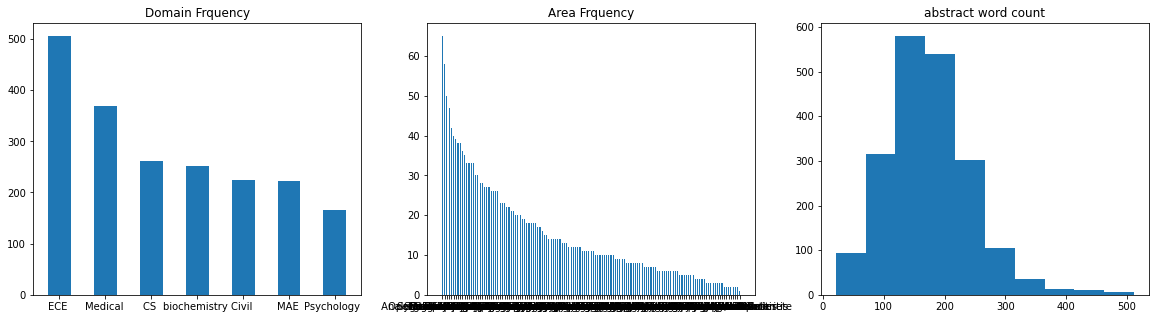

In [2]:
# read-in pre-labled research apper abstracts
df_paper_raw = pd.read_excel("data/WebOfScienceData.xlsx",sheet_name="abstracts")
print(len(df_paper_raw))
df_paper = df_paper_raw.head(2000) #use first 2000
print(df_paper.Domain.unique())

# remove puncutations and number, then tokenize each text
text_tokenized = list(map(lambda abstract_i:nltk.word_tokenize(re.sub(r'[^A-Za-z\s]','',abstract_i.lower())), df_paper['Abstract']))
len(text_tokenized)
df_paper['n_words']=list(map(lambda x:len(x),text_tokenized))

fig,axs = plt.subplots(1,3,figsize=(20,5))
categories = df_paper.Domain.value_counts().index
counts = df_paper.Domain.value_counts().values
axs[0].bar(categories, counts, width=0.5)
axs[0].set_title("Domain Frquency")

categories = df_paper.area.value_counts().index
counts = df_paper.area.value_counts().values
axs[1].bar(categories, counts, width=0.5)
axs[1].set_title("Area Frquency")

axs[2].hist(df_paper.n_words)
axs[2].set_title("abstract word count")

## remove stopwords, make biargam, lemmatize

/tmp/ipykernel_32672/1049156276.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words_removed']=list(map(lambda x:len(x),abstract_lemmatized))


Text(0.5, 1.0, 'abstract without stop words word count')

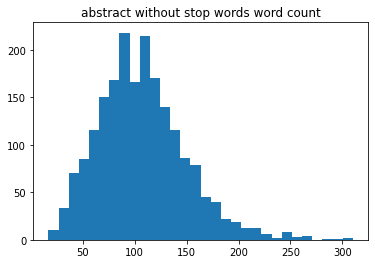

In [3]:
#helper function for lemmatization
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n' #if not belong to any, default is noun, inclunding N

def lemmatize_with_pos(abstract_toekenized):
    abstract_tagged = nltk.pos_tag(abstract_toekenized)
    tags = list(map(lambda token: get_wordnet_pos(token[1]),abstract_tagged))
    abstract_lemmatized = list(map(lemmatizer.lemmatize,abstract_toekenized,tags))
    return abstract_lemmatized


# Creating Bigram: find words frequently occur together
bigram = gensim.models.Phrases(text_tokenized, min_count=5, threshold=100)  
#come back to adjust the threshold value: (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold
bigram_freeze = bigram.freeze()
#import nltk lemmatizer
lemmatizer = WordNetLemmatizer()

def prepare_token(text_tokenized_list):
    # remove stopwords and puntuation, 
    text_stopwords_removed = list(map(lambda abstract: list(filter(lambda word: word not in stop_words, abstract)),text_tokenized_list))

    #apply biagram model
    word_and_bigram_list = list(map(lambda abstract_cleaned: bigram[abstract_cleaned],text_stopwords_removed))

    # lemmatize
    abstract_lemmatized = list(map(lemmatize_with_pos,word_and_bigram_list))
    return abstract_lemmatized

abstract_lemmatized = prepare_token(text_tokenized)
df_paper['n_words_removed']=list(map(lambda x:len(x),abstract_lemmatized))
plt.hist(df_paper.n_words_removed,bins=30)
plt.title("abstract without stop words word count")

['use', 'model', 'system', 'study', 'result', 'method', 'propose', 'show', 'control', 'base', 'present', 'design', 'analysis', 'high', 'data', 'also', 'patient', 'cell', 'effect', 'increase', 'two', 'different', 'time', 'develop', 'provide', 'new', 'process', 'include', 'rights_reserved', 'approach', 'compare', 'performance', 'test', 'algorithm', 'paper', 'low', 'c_elsevier', 'level', 'power', 'measure', 'structure', 'well', 'find', 'parameter', 'one', 'application', 'may', 'function', 'current', 'energy', 'obtain', 'condition', 'simulation', 'group', 'dynamic']


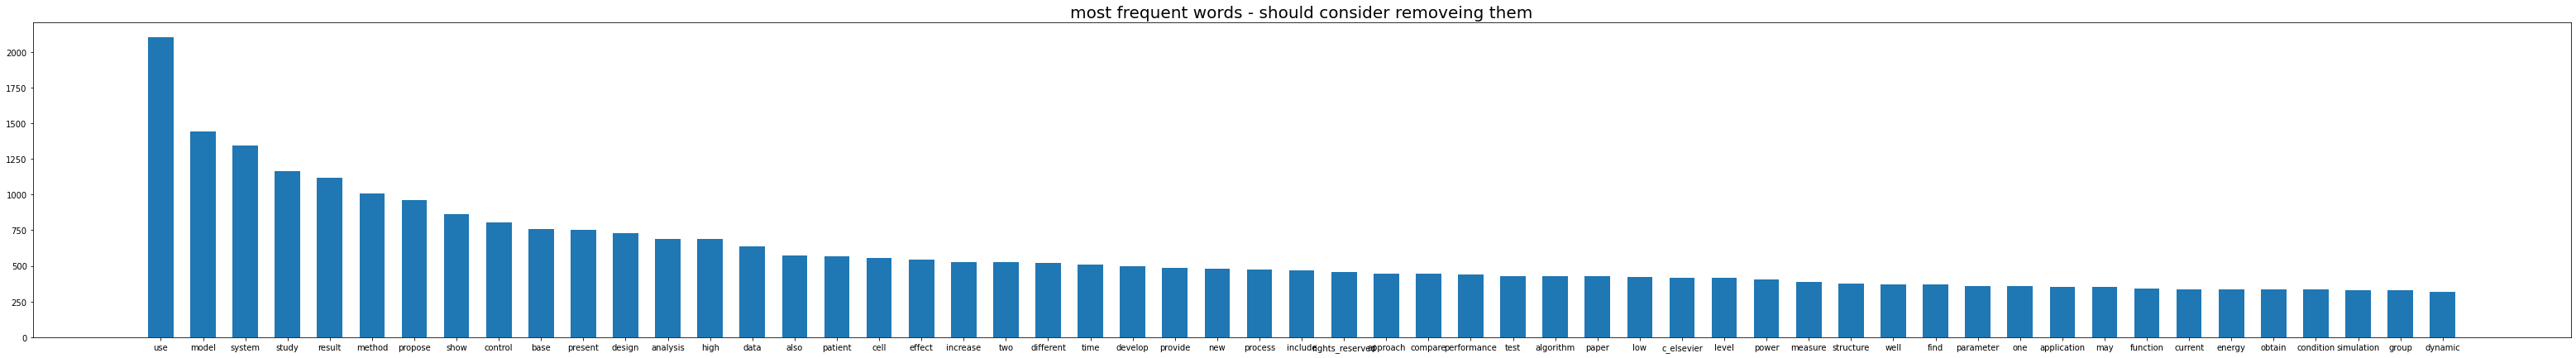

In [21]:
def check_frequent_words(corpus,top_n):
    all_corpus_together=np.concatenate(corpus)
    (word, counts) = np.unique(all_corpus_together, return_counts=True)
    frequencies = np.asarray((word, counts)).T
    count_df = pd.DataFrame(data=frequencies,columns = ['word','freq'])
    count_df.freq = count_df.freq.astype(int)
    count_df.sort_values(by=['freq'],axis=0,ascending=False,ignore_index=True,inplace=True)
    print(list(count_df.head(top_n).word))
    plt.figure(figsize=(top_n,7))
    plt.bar(count_df[:top_n].word,height=count_df[:top_n].freq,width=0.6,align='center')
    plt.title("most frequent words - should consider removeing them",fontsize=20)
    plt.show()
    return count_df

count_df =check_frequent_words(abstract_lemmatized,55)

['obtain', 'condition', 'simulation', 'group', 'dynamic', 'change', 'frequency', 'improve', 'treatment', 'reduce', 'demonstrate', 'circuit', 'work', 'however', 'expression', 'gene', 'response', 'signal', 'human', 'sample']


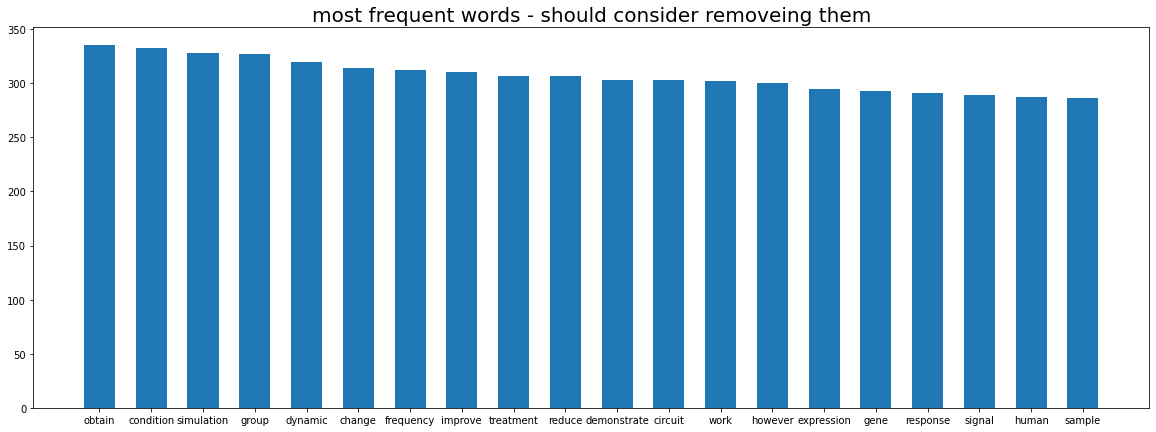

/tmp/ipykernel_32672/1339668137.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))


Text(200, 150, 'median length: 87')

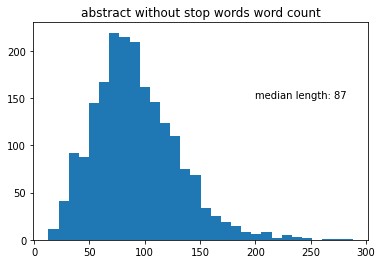

In [20]:
# remove top 50 most frequent words
top_n = list(count_df[:50].word)
abstract_lemmatized_cleaned = list(map(lambda abstract: list(filter(lambda word: word not in top_n, abstract)),abstract_lemmatized))
check_frequent_words(abstract_lemmatized_cleaned,top_n=20)

df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))
median_count = np.median(df_paper.n_words_lemmatize_clean)
plt.hist(df_paper.n_words_lemmatize_clean,bins=30)
plt.title("abstract without stop words word count")
plt.text(200,150,"median length: %d"%median_count,fontsize=10)


In [6]:
np.median(df_paper.n_words_lemmatize_clean)

89.0

## make dictionary and corpus for the inputs to Gensim LDA Model

In [7]:
# define mapping between words to integer ids
word2id = Dictionary(abstract_lemmatized_cleaned)
dictionary = word2id.token2id
vocab_size = len(dictionary)
print("total vocabulary size", vocab_size)
# word2id.token2id gives the dictonary between words and their ids

# define corpus from documents
# documents: a list of lists of strings
# corpus: bag of words: each text = [(word_id, frequency), (word_id, frequency)]
corpus = list(map(word2id.doc2bow,abstract_lemmatized))
print([(word2id[id], freq) for id, freq in corpus[1][:10]])

total vocabulary size 22487
[('p', 1), ('suggest', 1), ('accumulates', 1), ('accumulation', 2), ('across', 1), ('age', 2), ('aggregate', 1), ('among', 1), ('ap', 1), ('appear', 1)]


## Use LDA to extract topic distribution and topic-term distribution

In [22]:
# Train the model on the corpus.
lda_model = LdaModel(corpus, 
                num_topics=len(df_paper.Domain.unique()),
                id2word = word2id,
                random_state=121,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha='auto',
                per_word_topics=True)
# Save model to disk.
# temp_file = datapath("model")
# lda.save(temp_file)

# alpha = parameter for Dirichlet Distribution . higer alpha more towards the center, i.e. a mixture of different topic for one document
alpha = lda_model.alpha
print(alpha)
# alpha all parameters are equal => have no prior information to favor one component over any other

#beta = #distribution over word weights in each topic
topic_term_distribution = lda_model.get_topics()
print(np.shape(topic_term_distribution))

print(lda_model.print_topics(num_words=15)) 
#okay, i think i need remove "model", "use", "method", "system", "purpose", "result", "study", "show"



[(0, '0.017*"material" + 0.011*"sleep" + 0.010*"fracture" + 0.010*"heat" + 0.009*"wind" + 0.008*"machine" + 0.007*"tank" + 0.007*"start" + 0.005*"wind_turbine" + 0.005*"capable" + 0.005*"roll" + 0.005*"solid" + 0.004*"permanent_magnet" + 0.004*"site" + 0.004*"curve"'), (1, '0.009*"light" + 0.009*"telomere" + 0.008*"stimulation" + 0.008*"hdpp" + 0.007*"prosocial" + 0.006*"compound" + 0.006*"overcome" + 0.006*"ht" + 0.006*"potent" + 0.006*"tolerance" + 0.006*"nmolminmg" + 0.006*"et" + 0.005*"determination" + 0.005*"inhibition" + 0.005*"algorithms"'), (2, '0.008*"energy" + 0.007*"parameter" + 0.006*"simulation" + 0.005*"structure" + 0.005*"condition" + 0.005*"temperature" + 0.005*"measurement" + 0.005*"experimental" + 0.005*"area" + 0.005*"load" + 0.004*"water" + 0.004*"characteristic" + 0.004*"surface" + 0.004*"dynamic" + 0.004*"controller"'), (3, '0.018*"signal" + 0.017*"circuit" + 0.010*"voltage" + 0.010*"filter" + 0.009*"digital" + 0.009*"frequency" + 0.008*"loop" + 0.008*"current" + 

In [24]:
num2topic ={0:"Civil", 1:"Medical",2:"MAE",3:"ECE",4:"biochemistry",5:"CS", 6:"Psychology"}

## evalute model perplexity and coherence 
how to interpret these scores?
coherence score is not high

In [9]:
# A lower perplexity score indicates better generalization performance.
perplexity = lda_model.log_perplexity(corpus)
print('Perplexity: ', perplexity )

# get coherence value u_mass
# probability = the number of documents in which the word occurs divided by the total number of documents"
cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary = word2id,coherence='u_mass')
coherence_umass = cm.get_coherence() 
print('UMass Coherence Score: ', coherence_umass)

# Compute Coherence Score using c_v
# CV measure is based on the Pointwise Mutual Information score
coherence_model_lda = CoherenceModel(model=lda_model, texts=abstract_lemmatized_cleaned, dictionary=word2id, coherence="c_v")
coherence_cv = coherence_model_lda.get_coherence()
print('C_v Coherence Score: ', coherence_cv)

Perplexity:  -9.04370370668989
UMass Coherence Score:  -6.193833935408214
C_v Coherence Score:  0.4641668950515726


## visualize the model
0: CS <br>
1: Civil<br>
2: MAE <br>
3: ECE <br>
4: Psychology <br>
5: Biochemistry <br>
6: Medical <br>

In [12]:
vis_ldamodel = pyLDAvis.gensim_models.prepare(lda_model,corpus,word2id)
vis_ldamodel

/home/sxia1/.nlp_env/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/sxia1/.nlp_env/lib/python3.8/site-packages/past/builtins/mis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.157714 -0.184267       1        1  24.852655
6     -0.174651  0.228291       2        1  22.640206
5     -0.185710 -0.138176       3        1  21.968362
4     -0.051464  0.146895       4        1  18.172539
3      0.162981 -0.087769       5        1   6.194454
0      0.208039  0.006313       6        1   3.992679
1      0.198519  0.028713       7        1   2.179105, topic_info=            Term        Freq       Total Category  logprob  loglift
2899      signal  283.000000  283.000000  Default  30.0000  30.0000
302   expression  420.000000  420.000000  Default  29.0000  29.0000
443     material  242.000000  242.000000  Default  28.0000  28.0000
3528     circuit  200.000000  200.000000  Default  27.0000  27.0000
305         gene  320.000000  320.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1253    compound   25.457764   76.013854   Topic7  -5.0765   2.7324
1717  inhibition   21.400290   55.099362   Topic7  -5.2501   2.8805
873       status   15.975417   50.735243   Topic7  -5.5424   2.6707
620        human   16.349003  242.795110   Topic7  -5.5193   1.1282
3277        skin   15.307196   88.458373   Topic7  -5.5852   2.0720

[363 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
19619      7  0.959468          abi
20887      7  0.947769  aceclofenac
14647      7  0.970260         ache
353        1  0.513678      achieve
353        3  0.336293      achieve
...      ...       ...          ...
1288       3  0.551999         work
685        2  0.919856         year
685        3  0.047785         year
685        6  0.029865         year
769        1  0.995059        yield

[548 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 6, 5, 4, 1, 2])

In [18]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=3):
    """
    Compute c_v coherence for various number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus,num_topics=num_topics,
                id2word = dictionary,
                random_state=121,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha='auto',
                per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=word2id, corpus=corpus, texts=abstract_lemmatized_cleaned, start=5, limit=20, step=1)

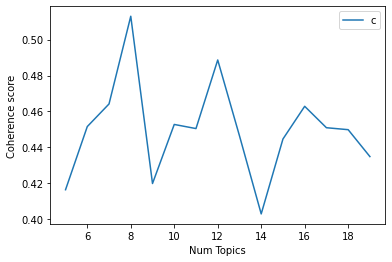

In [19]:
n = range(5, 20, 1)
plt.plot(n, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
model8 = model_list[3]
print(model8.print_topics(num_words=13)) 

[(0, '0.025*"fracture" + 0.011*"machine" + 0.011*"pregnancy" + 0.010*"motor" + 0.009*"cue" + 0.009*"contraceptive" + 0.008*"capability" + 0.008*"hybrid" + 0.008*"permanent_magnet" + 0.007*"choice" + 0.007*"material" + 0.006*"fusion" + 0.006*"shear"'), (1, '0.013*"telomere" + 0.011*"hdpp" + 0.008*"nmolminmg" + 0.008*"et" + 0.008*"adbchminaca" + 0.008*"suppression" + 0.007*"vi" + 0.007*"separate" + 0.007*"equipment" + 0.006*"ligand" + 0.006*"extracellular" + 0.005*"engineer" + 0.005*"embed"'), (2, '0.013*"stress" + 0.012*"water" + 0.011*"area" + 0.008*"symptom" + 0.007*"outcome" + 0.007*"transfer" + 0.006*"secondary" + 0.006*"resistance" + 0.005*"community" + 0.005*"inhibition" + 0.005*"improve" + 0.005*"soil" + 0.005*"perspective"'), (3, '0.016*"signal" + 0.015*"circuit" + 0.011*"frequency" + 0.010*"filter" + 0.009*"feedback" + 0.009*"voltage" + 0.008*"current" + 0.008*"node" + 0.008*"digital" + 0.007*"loop" + 0.006*"integrate" + 0.006*"verify" + 0.006*"converter"'), (4, '0.013*"express

# Using the LDA model, find the topic of any given document
#### lda built in model

In [44]:
# test on 2000-2500 rows from the real data
# step1:  given an abstract/text, tokenize, find biargram, remove popular words, turn it into a bag of words
def prepare_text(text_list,BOW=False):
    tokenized = list(map(lambda text_i:nltk.word_tokenize(re.sub(r'[^A-Za-z\s]','',text_i.lower())),text_list))
    text_uncategorized = prepare_token(tokenized)
    # map corpus to a bag of words, lda doc2idx ignore unknown words
    corpus_uncategorized  = list(map(word2id.doc2bow,text_uncategorized))
    if BOW:
        corpus_uncategorized  = list(map(lambda document: np.array(word2id.doc2bow(document)),text_uncategorized))
    else:
        corpus_uncategorized  = list(map(lambda document: np.array(word2id.doc2idx(document)),text_uncategorized))
        corpus_uncategorized = list(map(lambda document: document[document>=0],corpus_uncategorized))
    return corpus_uncategorized

#step2: infer topic distribution
def get_weight_each_topic(i,t_predict):
    find = t_predict[list(map(lambda topic: i in topic, t_predict))]
    if len(find)==0:
        return 0.0
    else:
        return find[0][1]

def get_topic_dist(model,text):
    t_predict = np.array(model[text][0])
    topic_dist_d = list(map(lambda i:get_weight_each_topic(i,t_predict),range(7)))
    return topic_dist_d

df_test = df_paper_raw[2000:2500]
topic2num = {"Civil": 0, "Medical":1, "MAE":2, "ECE":3, "biochemistry":4, "CS":5,"Psychology":6}
df_test.Domain = df_test.Domain.str.replace(r'\s','')
df_test['Domain_No'] = df_test.Domain.map(topic2num)
corpus_uncategorized = prepare_text(df_test.Abstract,BOW=True)
# corpus_uncategorized[1]
topic_weight_matrix = list(map(lambda text_i:get_topic_dist(lda_model,text_i),corpus_uncategorized))
dominant_topic = np.argmax(topic_weight_matrix,axis=1)
predict_compare = pd.DataFrame({"actual":df_test.Domain_No,"predicted":dominant_topic})
predict_compare["correct"] = np.equal(predict_compare.actual,predict_compare.predicted)
accuracy = np.sum(predict_compare['correct'])/len(predict_compare)
print("accuracy:", accuracy)
predict_compare.head()

/tmp/ipykernel_32672/1950728432.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test.Domain = df_test.Domain.str.replace(r'\s','')
/home/sxia1/.nlp_env/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/tmp/ipykernel_32672/1950728432.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Domain_No'] = df_test.Domain.map(topic2num)


accuracy: 0.354


,actual,predicted,correct
2000,4,4,True
2001,0,2,False
2002,2,4,False
2003,0,5,False
2004,2,4,False


In [43]:
lda_model[corpus_uncategorized[1]][0]

[(0, 0.10804731),
 (2, 0.4671807),
 (3, 0.043634847),
 (4, 0.20106961),
 (5, 0.13779163),
 (6, 0.040779144)]

# generate synthetic data using $\alpha$ and $\bm{\beta}$ to 

In [45]:
num2topic = {0:"Civil", 1:"Medical",2:"MAE",3:"ECE",4:"biochemistry",5:"CS", 6:"Psychology"}

# Possion distribution: draw sample length, lambda = median from the data
# alpha: topic mixture of each synethic text
# beta: topic-term distribution
def lda_gen(vocabulary,beta,alpha,possion_lambda):
    xi = np.random.poisson(possion_lambda) #length = sample from poisson dist
    v = np.shape(beta)[0]
    topic_proportion = np.random.dirichlet(alpha) # generate topic proportion based of a text dist
    dominant_domain = num2topic[np.argmax(topic_proportion)]
    topic_list = np.random.choice(range(v),xi,p=topic_proportion) #sample from topic proportion dist, 

    #pick a word for each topic in each document
    # frequency of the topics = topics mixture in each document
    word_bag = []
    for topic_index in topic_list:
        word = np.random.choice(vocabulary,p=beta[topic_index])
        word_bag.append(word)
    return (dominant_domain,word_bag)

vocabulary = list(dictionary.keys())
alpha = lda_model.alpha
beta = lda_model.get_topics()
possion_lambda = median_count

synthetic_data_size = 2500
synthetic_data = [ lda_gen(vocabulary,beta,alpha,possion_lambda) for _ in range(synthetic_data_size)]
synthetic_df = pd.DataFrame(synthetic_data,columns=['Domain','Abstract'])
synthetic_df.Abstract = synthetic_df.Abstract.map(lambda a: " ".join(a))
synthetic_df.to_csv("mockdata.csv",index=False)



# Categorize the synthetic data with lda probabilistic classifier

In [46]:

# read data
mock_data = pd.read_csv("mockdata.csv", engine='python')
# topic2num = {"CS": 0, "Civil":1, "MAE":2, "ECE":3, "Psychology":4, "Biochemistry":5,"Medical":6}

mock_data.head()

,Domain,Abstract
0,MAE,epigenetic n enrol thus diversity app bias caa...
1,Psychology,socially change food emerge hei parameter tsh ...
2,Civil,contextaware adhesively bimetallic quantity cc...
3,CS,theoretical mg biology context terrier politic...
4,MAE,decide generally surface set openended follow ...


In [64]:
# extract alpha and beta from the mock data
num_topics = 7
documents = list(map(lambda abstract:abstract.split(" "),mock_data.Abstract[:2000]))
mockdata_word2id = Dictionary(documents)
mock_corpus = [mockdata_word2id .doc2bow(text) for text in documents]
mockdata_lda_model = LdaModel(mock_corpus, 
                num_topics=len(mock_data.Domain.unique()),
                id2word = mockdata_word2id,
                random_state=130,
                update_every=1,
                chunksize=100,
                passes=10,
                alpha='auto',
                per_word_topics=True)
print("alpha", mockdata_lda_model.alpha)
print("beta",mockdata_lda_model.show_topics(15))

alpha [0.6350681 2.226943  2.1324077 1.3235765 2.0217237 0.7682069 1.53954  ]
beta [(0, '0.006*"expect" + 0.005*"skill" + 0.005*"professional" + 0.004*"aggressive" + 0.004*"responsible" + 0.004*"board" + 0.004*"nurse" + 0.004*"relapse" + 0.004*"mother" + 0.004*"whole"'), (1, '0.007*"function" + 0.007*"one" + 0.007*"network" + 0.007*"work" + 0.006*"case" + 0.005*"problem" + 0.005*"research" + 0.005*"set" + 0.005*"consider" + 0.005*"however"'), (2, '0.009*"energy" + 0.008*"parameter" + 0.008*"condition" + 0.007*"simulation" + 0.007*"structure" + 0.007*"experimental" + 0.007*"characteristic" + 0.006*"value" + 0.005*"area" + 0.005*"load"'), (3, '0.008*"material" + 0.007*"resource" + 0.006*"machine" + 0.004*"second" + 0.004*"heat" + 0.004*"fracture" + 0.004*"sleep" + 0.004*"failure" + 0.004*"effectiveness" + 0.004*"source"'), (4, '0.010*"expression" + 0.007*"gene" + 0.007*"activity" + 0.006*"mechanism" + 0.005*"human" + 0.005*"protein" + 0.005*"demonstrate" + 0.004*"potential" + 0.004*"indi

In [66]:
num2topicMock = {0:"Medicial",1:"CS",2:"MAE",3:"Civil",4:"biochemistry",5:"ECE",6:"Psychology"}
topic2numMock = {"Medical":0,"CS":1,"MAE":2,"Civil":3,"biochemistry":4,"ECE":5,"Psychology":6}

In [65]:
# A lower perplexity score indicates better generalization performance.
mock_perplexity = mockdata_lda_model.log_perplexity(mock_corpus)
print('Perplexity: ', mock_perplexity )

# get coherence value u_mass
# probability = the number of documents in which the word occurs divided by the total number of documents"
mock_cm = CoherenceModel(model=mockdata_lda_model, corpus=mock_corpus, dictionary = mockdata_word2id,coherence='u_mass')
mock_coherence_umass = mock_cm.get_coherence() 
print('UMass Coherence Score: ', mock_coherence_umass)

# Compute Coherence Score using c_v
# CV measure is based on the Pointwise Mutual Information score
mock_coherence_model_lda = CoherenceModel(model=mockdata_lda_model, texts=documents, dictionary=mockdata_word2id, coherence="c_v")
mock_coherence_cv = mock_coherence_model_lda.get_coherence()
print('C_v Coherence Score: ', mock_coherence_cv)

Perplexity:  -9.04749505007605
UMass Coherence Score:  -3.805549133782243
C_v Coherence Score:  0.4916114180924918


In [75]:
def get_weight_each_topic(i,t_predict):
    find = t_predict[list(map(lambda topic: i in topic, t_predict))]
    if len(find)==0:
        return 0.0
    else:
        return find[0][1]

def get_topic_dist(model,text):
    t_predict = np.array(model[text][0])
    topic_dist_d = list(map(lambda i:get_weight_each_topic(i,t_predict),range(7)))
    return topic_dist_d

# accuracy on the training dataset
topic_weight_matrix = list(map(lambda text_i:get_topic_dist(mockdata_lda_model,text_i),mock_corpus))
dominant_topic = np.argmax(topic_weight_matrix,axis=1)
mock_data['Domain_No'] = mock_data.Domain.map(topic2numMock)
predict_compare = pd.DataFrame({"actual": mock_data.Domain_No[:2000],"predicted":dominant_topic})
predict_compare["correct"] = np.equal(predict_compare.actual,predict_compare.predicted)
accuracy = np.sum(predict_compare['correct'])/len(predict_compare)
print(accuracy)
predict_compare.head()

0.7275


,actual,predicted,correct
0,2,2,True
1,6,1,False
2,3,3,True
3,1,1,True
4,2,6,False


In [77]:
# compute accuracy by domain
predict_compare.group_by('actual').apply(lambda grp: np.sum(predict_compare.correct/len(grp))

SyntaxError: unexpected EOF while parsing (2160559482.py, line 2)

In [ ]:
#test on 2000-2500 in te mock data
mock_test = mock_data[2000:2500]
documents = list(map(lambda abstract:abstract.split(" "),mock_test.Abstract))
mock_corpus_test = [mockdata_word2id .doc2bow(text) for text in documents]

topic_weight_matrix_test = list(map(lambda text_i:get_topic_dist(mockdata_lda_model,text_i),mock_corpus_test))
dominant_topic_test = np.argmax(topic_weight_matrix_test,axis=1)
mock_test['Domain_No'] = mock_test.Domain.map(topic2numMock)
predict_compare_test = pd.DataFrame({"actual": mock_test.Domain_No,"predicted":dominant_topic_test})
predict_compare_test["correct"] = np.equal(predict_compare_test.actual,predict_compare_test.predicted)
test_accuracy = np.sum(predict_compare_test['correct'])/len(predict_compare_test)
print(test_accuracy)
predict_compare_test.head()

# Ignore
#### Naive Bayes (assume each text only has one topic, will try this and see how bad)
$$
\begin{align}
topic=&argmax_{topic_i} p(words|topic_i)p(topic_i)\\
=&argmax_{topic_i} p(word1|topic_i)p(word2|topic_i)...|p(topic_i)\\
=&argmax_{topic_i} \sum_{word_j} log p(word_j|topic_i)|p(topic_i)
\end{align}
$$

#### Better approach
Since we used LDA, probably better finding topic mixture for each given document. + One research paper can include multiple domains <br>
Get the topic assignment for every word in the new document -> the distribution of topics in that document. <br>
For each document:
we know: W, the text <br>
Unknown: $\phi$, distribution over words for each topic (but we will use what we had for $\bm{\beta}$ from training our LDA model, SparkML Rstudio says orignially use $\bm{\beta}$, bu later paper uses $\phi$ [https://spark.rstudio.com/reference/ml_lda]. Blei extends $\bm{\beta}$ as a random varible drawn from a Dirichlet distirbution for smoothing purpose)<br> 
&emsp;&emsp; &emsp; &emsp;$z$ latent variable, topic of each word <br>
&emsp;&emsp; &emsp; &emsp;$\bm{\theta}$ latent variables, distribution over topics for each document<br>
Goal: find z that maximzes $p(\bm{z}|\bm{w}) -> p(\bm{w}|\bm{z})$

#### MCMC using Gibbs Sampling
Find the conditional probability distribution of a single word’s topic assignment conditioned on the rest of the topic assignments.<br>
$$\begin{align}
p(z_i|\bm{z_{-i}},\bm{\alpha},\bm{\beta},\bm{w}) =& \frac{p(z_i,\bm{z_{-i}},\bm{w}|\bm{\alpha},\bm{\beta})}{p(\bm{z_{-i}},\bm{w}|\bm{\alpha},\bm{\beta})} \\
 &\propto p(z_i,\bm{z_{-i}},\bm{w}|\bm{\alpha},\bm{\beta}) \\
 &\propto P(\bm{z},\bm{w}|\bm{\alpha},\bm{\beta}) 
\end{align} $$

$$
\begin{align}
p(\bm{z},\bm{w}|\bm{\alpha},\bm{\beta}) =& \int p(\bm{z},\bm{w},\bm{\theta}|\bm{\alpha},\bm{\beta})d\bm{\theta}\\
=& \int p(\bm{\theta}|\bm{\alpha}) p(\bm{z}|\bm{\theta}) p(\bm{w}|\bm{\beta}_{\bm{z}}) d\bm{\theta} \\
= & p(\bm{w}|\bm{\beta}_{\bm{z}}) \int p(\bm{\theta}|\bm{\alpha}) p(\bm{z}|\bm{\theta}) d\bm{\theta}, 
\end{align}$$
where
$$
\begin{align}
p(\bm{w}|\bm{\beta}_{\bm{z}}) = \prod_{j} {\bm{\beta}_{z_j,w_j}}.
\end{align}
$$
Expand the integral term:<br>
The 1st term is: $$ p(\bm{z}|\bm{\theta})= \prod_i \bm{\theta}_{z_i}.$$
The 2nd term is:
$$
\begin{align}
p(\bm{\theta}|\bm{\alpha}) = Dir(\bm{\theta},\bm{\alpha}) = \frac{1}{\Beta(\bm{\alpha})}\prod_{k=0}^{k=N} \theta_k^{\alpha_k-1},
\end{align}
$$
where $N$ is the number of topics, and $\frac{1}{\Beta(\alpha)}$, the normalization constant is given by the multivariate beta function and comupted from gamma function as
$$\Beta(\bm{\alpha}) = \frac{\prod_{k=1}^{k=N}\Gamma(\alpha_k)}{\Gamma(\sum_{k=1}^{k=N}\alpha_k)}.$$

Plug in these two terms into the integral term:
$$
\begin{align}
\int p(\bm{\theta}|\bm{\alpha}) p(\bm{z}|\bm{\theta}) d\bm{\theta} =& \int \prod_i \bm{\theta}_{z_i} \frac{1}{\Beta(\bm{\alpha})}\prod_{k=0}^{k=N} \theta_k^{\alpha_k-1} d\bm{\theta}\\
= & \frac{1}{\Beta(\bm{\alpha})} \int \prod_i \bm{\theta}_{z_i} \prod_{k=0}^{k=N} \theta_k^{\alpha_k-1} d\bm{\theta}\\
= & \frac{1}{\Beta(\bm{\alpha})} \int \prod_k \theta_k ^{n_k+\alpha_k-1} d\bm{\theta} \hskip{0.5 in} (n_k =\textrm{ the number of times }z_i=k)\textrm{, and define }\bm{n} = [n_1,n_2,...,n_k] \\
= & \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})} \int \frac{1}{\Beta(\bm{\alpha}+\bm{n})} \prod_k \theta_k ^{n_k+\alpha_k-1} d\bm{\theta} \\
=& \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})} \int Dir(\bm{\theta},\bm{\alpha}+\bm{n}) d\bm{\theta} \\
=& \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})}
\end{align}
$$
Thus 
$$ 
p(\bm{w},\bm{z}|\bm{\alpha},\bm{\beta})=\frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})} \prod_{j} {\bm{\beta}_{z_j,w_j}}.
$$
Conditional distribution for how to draw topic $z_i$ for word $w_i$:
$$\begin{align}
p(z_i|\bm{z_{-i}},\bm{w},\bm{\alpha},\bm{\beta}) =& \frac{p(\bm{z},\bm{w}|,\bm{\alpha},\bm{\beta})}{p(\bm{z_{-i}},\bm{w}|,\bm{\alpha},\bm{\beta})}\\
\propto &  \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha})} \prod_{j} {\bm{\beta}_{z_j,w_j}} / \frac{\Beta(\bm{\alpha}+\bm{n_{-i}})}{\Beta(\bm{\alpha})} \prod_{j \neq i} {\bm{\beta}_{z_j,w_j}} \\
\propto &  \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha}+\bm{n_{-i}})}\frac{\prod_{j} {\bm{\beta}_{z_j,w_j}} }{\prod_{j \neq i} {\bm{\beta}_{z_j,w_j}} }\\
\propto & \frac{\Beta(\bm{\alpha}+\bm{n})}{\Beta(\bm{\alpha}+\bm{n_{-i}})}\bm{\beta}_{z_i,w_i}\\
\propto & \frac{\prod_{k=1}^{k=N}\Gamma((\bm{\alpha}+\bm{n})_k)}{\Gamma(\sum_{k=1}^{k=N}(\bm{\alpha}+\bm{n})_k)} \frac{\Gamma(\sum_{k=1}^{k=N}(\bm{\alpha}+\bm{n_{-i}})_k)}{\prod_{k=1}^{k=N}\Gamma((\bm{\alpha}+\bm{n_{-i}})_k)} \bm{\beta}_{z_i,w_i}
\end{align} $$


The sampling process is:
* Initailize $\bm{z}$
* while not max_iteration/not converged:
    * for each word $w_i$ in $\bm{w}$:
        1. compute  conditional_p = $p(z_i|\bm{z_{-i}},\bm{w},\bm{\alpha},\bm{\beta})$ ( probabily of $z_i=k$ for each topic $k$ from $N$ total topics)
        2. draw $z_i$ from Multinomial(conditional_p)
        3. update $z_i$, save this 
    * estimate $\bm{\theta}$:$$\theta_k = \frac{n_k+\alpha_k}{\sum_{k} n_k+\alpha_k}$$
    * compute $p(\bm{\theta},\bm{w},\bm{z}|\alpha,\beta)$:
            $$p(\bm{\theta},\bm{w},\bm{z}|\alpha,\beta) = \log p(\bm{\theta}|\bm{\alpha})+ \sum_{i=0}^{len(\bm{w})}\log p(w_i|z_i,\bm{\beta})  +\log p(z_i|\bm{\theta}) = \log p(\bm{\theta}|\bm{\alpha}) +\sum_{i=0}^{len(\bm{w})} \log \beta_{zi,wi} +\log p(z_i|\bm{\theta})            $$



In [153]:
class GibbsSampler_Predict:
    def __init__(self, n_topics,alpha=0.2,beta=0.1):
        self.n_topics = n_topics
        self.alpha = alpha
        self.beta = beta
        self.theta = 0
        self.z_vec = 0
        self.w_vec = None
        self.text_length = 0
        self.maxiter = 5
        self.log_likelihood_list = []


    def initialize(self,words):
        self.w_vec = words
        self.text_length = len(words)
        # initialize z_vec closer to the posterior distribution based on alpha parameter
        self.theta = np.random.dirichlet(self.alpha)
        self.z_vec = np.random.choice(range(self.n_topics),len(self.w_vec),p=self.theta)
    
    def _conditional_prob(self,i):
        # conditional probablity distribution of zi=k for word w_i given alpha and beta
        z_matrix_zi_all_k = np.tile(self.z_vec,(self.n_topics,1))
        z_matrix_zi_all_k[:,i] = np.arange(0,self.n_topics,1)
        n_matrix_all_k = np.array(list(map(lambda j: np.sum(z_matrix_zi_all_k==j,axis=1),range(self.n_topics)))).T

        z_matrix_min_i = np.delete(z_matrix_zi_all_k,i,1)
        n_matrix_min_i = np.array(list(map(lambda j: np.sum(z_matrix_min_i==j,axis=1),range(self.n_topics)))).T

        top = np.prod(gamma(self.alpha+n_matrix_all_k),axis=1)/gamma(np.sum(self.alpha+n_matrix_all_k,axis=1))
        bottom= np.prod(gamma(self.alpha+n_matrix_min_i),axis=1)/gamma(np.sum(self.alpha+n_matrix_min_i,axis=1))
        p_wi_zi = self.beta[:,self.w_vec[i]]

        prob = top/bottom*p_wi_zi
        prob_normalized = prob/np.sum(prob)

        return prob_normalized
    
    def _estimate_theta(self):
        n_vec = np.array(list(map(lambda j: np.sum(self.z_vec==j),range(self.n_topics))))
        theta = (n_vec+alpha)/np.sum(n_vec+alpha)
        return theta

    def _logP_theta_z_w(self,theta):
        logP_w_z_theta = np.sum(list(map(lambda i: np.log(theta[self.z_vec[i]])+np.log(beta[(self.z_vec[i],self.w_vec[i])]),range(self.text_length))))
        logP_theta_alpha = dirichlet.logpdf(theta, self.alpha)
        logP = logP_theta_alpha+logP_w_z_theta
        return logP


    def sample(self,maxiter=5):
        self.maxiter = maxiter
        iter = 0
        #got to final estimated z_vec
        while iter < maxiter:
                iter += 1
                for i in range(self.text_length):
                    conditional_p = self._conditional_prob(i)
                    z_i_new = np.argmax(np.random.multinomial(1,conditional_p))# sample topic for i_th word in W from conditional probability
                    self.z_vec[i] = z_i_new        
                theta = self._estimate_theta()
                log_likelihood = self._logP_theta_z_w(theta)
                self.log_likelihood_list.append(log_likelihood)
        self.theta = theta
    
    def plot(self):
        plt.plot(np.arange(0,self.maxiter,1),self.log_likelihood_list)
        plt.xlabel("iteration")
        plt.ylabel("log likliehood")
        plt.show()



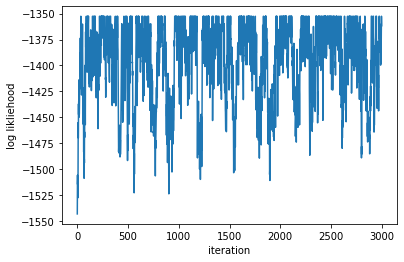

[8.87311486e-04 8.87311486e-04 8.87311486e-04 8.87311486e-04
 9.88464951e-01 8.87311486e-04 7.09849161e-03]
most salient topic: 4
Gensim result: [(0, 0.43223852), (5, 0.5619697)]


In [168]:
corpus_uncategorized = prepare_text(df_test.Abstract)
corpus_d = corpus_uncategorized[1]

GBS_sampler = GibbsSampler_Predict(n_topics=7,alpha=alpha,beta=beta)
GBS_sampler.initialize(corpus_d)
GBS_sampler.sample(maxiter=3000)
GBS_sampler.plot()

topic_weight = GBS_sampler.theta
dominant_topic = np.argmax(topic_weight)
print(topic_weight)
print("most salient topic:",dominant_topic)
# gensim implementation
topic_dist_inferred = lda_model[corpus[0]]
print("Gensim result:", topic_dist_inferred)

# use $\alpha$ and $\bm{\beta}$ to generate synthetic data

In [166]:

topic_dictionary = {0: "CS", 1: "Civil", 2: "MAE", 3: "ECE",4: "Psychology", 5: "Biochemistry", 6: "Medical"}

# Possion distribution: draw sample length, lambda = median from the data
# alpha: topic mixture of each synethic text
# beta: topic-term distribution
def lda_gen(vocabulary,beta,alpha,possion_lambda):
    xi = np.random.poisson(possion_lambda) #length = sample from poisson dist
    v = np.shape(beta)[0]
    topic_proportion = np.random.dirichlet(alpha) # generate topic proportion based of a text dist
    dominant_domain = topic_dictionary[np.argmax(topic_proportion)]
    topic_list = np.random.choice(range(v),xi,p=topic_proportion) #sample from topic proportion dist, 

    #pick a word for each topic in each document
    # frequency of the topics = topics mixture in each document
    word_bag = []
    for topic_index in topic_list:
        word = np.random.choice(vocabulary,p=beta[topic_index])
        word_bag.append(word)
    return (dominant_domain,word_bag)

vocabulary = list(dictionary.keys())
alpha = lda_model.alpha
beta = lda_model.get_topics()
possion_lambda = median_count

synthetic_data_size = 1000
synthetic_data = [ lda_gen(vocabulary,beta,alpha,possion_lambda) for _ in range(synthetic_data_size)]
synthetic_df = pd.DataFrame(synthetic_data,columns=['Domain','Abstract'])
synthetic_df.Abstract = synthetic_df.Abstract.map(lambda a: " ".join(a))
synthetic_df.to_csv("mockdata.csv",index=False)



## Categorize the synthetic data with lda probabilistic classifier

In [185]:

mock_data = pd.read_csv("mockdata.csv", engine='python')
topic2num = {"CS": 0, "Civil":1, "MAE":2, "ECE":3, "Psychology":4, "Biochemistry":5,"Medical":6}
mock_data['Domain_No'] = mock_data.Domain.map(topic2num)
mock_data.head()

{'CS': 0, 'Civil': 1, 'MAE': 2, 'ECE': 3, 'Psychology': 4, 'Biochemistry': 5, 'Medical': 6}


,Domain,Abstract,Domain_No
0,MAE,quality drug h potentially calculate windinduc...,2
1,Biochemistry,additionally disengagement validation style qr...,5
2,Medical,lipopolysaccharide hyperbolic blueberry insert...,6
3,Medical,allow rate regard biological voltage divide pr...,6
4,Civil,request rmse easytofollow mean depression body...,1


In [186]:
# extract alpha and beta from the mock data
documents = list(map(lambda abstract:abstract.split(" "),mock_data.Abstract))
mockdata_word2id = Dictionary(documents)
mock_corpus = [mockdata_word2id .doc2bow(text) for text in documents]
mockdata_model = LdaModel(
    mock_corpus,
    id2word=mockdata_word2id,
    num_topics=7,
)
print("alpha", mockdata_model.alpha)
print("beta",mockdata_model.show_topics())

alpha [0.14285715 0.14285715 0.14285715 0.14285715 0.14285715 0.14285715
 0.14285715]
beta [(0, '0.002*"obtain" + 0.002*"condition" + 0.002*"temperature" + 0.002*"expression" + 0.002*"well" + 0.002*"treatment" + 0.002*"one" + 0.002*"rate" + 0.002*"sample" + 0.002*"suggest"'), (1, '0.002*"may" + 0.002*"however" + 0.002*"well" + 0.002*"one" + 0.002*"circuit" + 0.002*"sample" + 0.002*"parameter" + 0.002*"demonstrate" + 0.002*"group" + 0.002*"water"'), (2, '0.002*"structure" + 0.002*"treatment" + 0.002*"one" + 0.002*"efficiency" + 0.002*"gene" + 0.002*"parameter" + 0.002*"current" + 0.002*"novel" + 0.002*"measurement" + 0.002*"dynamic"'), (3, '0.002*"may" + 0.002*"technique" + 0.002*"range" + 0.002*"investigate" + 0.002*"condition" + 0.002*"find" + 0.002*"c" + 0.002*"large" + 0.002*"novel" + 0.002*"one"'), (4, '0.003*"structure" + 0.002*"condition" + 0.002*"application" + 0.002*"reduce" + 0.002*"well" + 0.002*"expression" + 0.002*"frequency" + 0.002*"type" + 0.002*"one" + 0.002*"determine"

In [188]:
def get_weight_each_topic(i,t_predict):
    find = t_predict[list(map(lambda topic: i in topic, t_predict))]
    if len(find)==0:
        return 0.0
    else:
        return find[0][1]

def get_topic_dist(model,text):
    t_predict = np.array(model[text])
    topic_dist_d = list(map(lambda i:get_weight_each_topic(i,t_predict),range(7)))
    return topic_dist_d


topic_weight_matrix = list(map(lambda text_i:get_topic_dist(mockdata_model,text_i),mock_corpus))
dominant_topic = np.argmax(topic_weight_matrix,axis=1)
predict_compare = pd.DataFrame({"actual": mock_data.Domain_No,"predicted":dominant_topic})
predict_compare["correct"] = np.equal(predict_compare.actual,predict_compare.predicted)
accuracy = np.sum(predict_compare['correct'])/len(predict_compare)
print(accuracy)
predict_compare.head()

0.138


,actual,predicted,correct
0,2,3,False
1,5,4,False
2,6,3,False
3,6,2,False
4,1,2,False


In [184]:
df_test = df_paper_raw[2000:2500]
df_test.head()

,Y1,Y2,Y,Domain,area,keywords,Abstract
2000,6,3,128,biochemistry,Immunology,CARs; TRUCKs; Tumor-Targeted; Nanoparticles; ...,Adoptive transfer of antigen-specific T cells ...
2001,4,6,67,Civil,Stealth Technology,adsorption; conductive textiles; Olney addres...,Adsorption at the liquid-solid interface is wi...
2002,3,6,58,MAE,Thermodynamics,HIC; Protein unfolding; Mathematical modeling...,"Adsorption behavior of unstable proteins, i.e...."
2003,4,8,69,Civil,Solar Energy,Adsorption; ORC; Cooling and power generation...,Adsorption cooling and Organic Rankine Cycle (...
2004,3,6,58,MAE,Thermodynamics,adsorption; anion exchange membrane; anionic ...,Adsorption is a widely used technique for the ...


0.15


,actual,predicted,correct
0,0,6,False
1,1,3,False
2,2,6,False
3,2,5,False
4,3,5,False
